<a href="https://colab.research.google.com/github/toby-j/COM3025-CW/blob/main/CNN_with_Demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input, BatchNormalization, Activation, concatenate
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from keras import Sequential
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import PIL.Image
from torchvision import models, transforms
from matplotlib import pylab as P
import numpy as np
from PIL import Image
import tensorflow
from keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Global functions

In [2]:
def plot_loss(history):
  # Plotting the loss graph
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plotting the accuracy graph
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [3]:
def plot_confusion_matrix(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=-1)
  
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred_classes)

  labels = list(set(y_test) | set(y_pred_classes))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)

  plt.show()

In [4]:
def output_metrics(model, data, labels):
  predictions = model.predict(data)

  y_pred  = np.argmax(predictions, axis=-1)

  print(f'Accuracy score: {accuracy_score(labels, y_pred)}')
  print(f'F1 score: {f1_score(labels, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(labels, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(labels, y_pred, average="weighted")}')

In [5]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [6]:
def load_images_from_folder(folder_path):
    image_paths = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            image_paths.append(img_path)
    return image_paths

In [7]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [8]:
def normaliseGradients(image_3d, percentile=99):
    image_2d = np.sum(np.abs(image_3d), axis=2)

    # Get max pixel value in the image
    vmax = np.percentile(image_2d, percentile)
    # Get minimum pixel value in the image
    vmin = np.min(image_2d)

    # Normalise the values. We clip intensities so values lower than 0 are equal 0.
    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

In [9]:
def convert_to_boolean_mask(image):
    # Convert the image to a NumPy array
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Create a boolean mask where white pixels are True and black pixels are False
    binary_image = np.where(image == 255, False, True)  # Assuming white pixels are represented as 255

    cropped_image = cv2.resize(binary_image.astype(np.uint8), image_size)

    return cropped_image

In [10]:
def calculate_overlap(g, m):
    # Invert the mask, so the pixels outside are True.
    # Replace where the mask is False, with a 0 in the same location in raw_gradients
    segment = np.where(np.array(m), np.array(g), 0)

    # We now have just the gradients in a 2D vector of the pixels outside the bounding box
    sum_mask_segment = np.sum(segment)
    # Find what percentage the outside pixels make up of the full gradient image by summing both 2D vectors
    total_sum = np.sum(g)
    # What percentage are the gradients outside the segment of the full gradient vector
    overlap = (sum_mask_segment / total_sum) * 100

    return overlap

In [11]:
def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

In [12]:
transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [13]:
def visualiseImageToHeatmap(image_3d, percentile=99):
    r"""Returns a 3D tensor as RGB 3D heatmap
    Pixels with higher weightage in sailiency heatmap will most saturated and will correspond to high RGB values in output heatmap_rgb
  """
    image_2d = normaliseGradients(image_3d)
    # Create heatmap using "jet" colormap, which returns an RGBA image
    heatmap = plt.get_cmap('jet')(image_2d) * 255

    # Normalise to 0,255 so it's visible when pasted
    return Image.fromarray(heatmap.astype(np.uint8), mode='RGBA'), image_2d

In [14]:
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

In [15]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

# Smoothgrad

In [16]:
class_idx_str = 'class_idx_str'

In [17]:
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'

In [18]:
expected_keys = [INPUT_OUTPUT_GRADIENTS]

In [19]:
conv_layer_outputs = {}

In [20]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = new_model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = new_model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {CONVOLUTION_LAYER_VALUES: conv_layer,
                    CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [21]:
def format_and_check_call_model_output(self, output, input_shape, expected_keys):
  """Converts keys in the output into an np.ndarray, and confirms its shape.

  Args:
    output: The output dictionary of data to be formatted.
    input_shape: The shape of the input that yielded the output
    expected_keys: List of keys inside output to format/check for shape agreement.

  Raises:
      ValueError: If output shapes do not match expected shape."""
  # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
  # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
  # only checks the outermost dimension of output to match input_shape (i.e. the batch size
  # should be the same).
  check_full_shape = [INPUT_OUTPUT_GRADIENTS]
  for expected_key in expected_keys:
    output[expected_key] = np.asarray(output[expected_key])
    expected_shape = input_shape
    actual_shape = output[expected_key].shape
    if expected_key not in check_full_shape:
      expected_shape = expected_shape[0]
      actual_shape = actual_shape[0]
    if expected_shape != actual_shape:
      raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                      expected_shape, actual_shape))

In [22]:
# Output of the last convolution layer for the given input, including the batch
# dimension.
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the last convolution layer, including the batch dimension.
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the input. Shape should be the same shape as x_value_batch.
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
# Value of the output being explained (the logit/softmax value).
OUTPUT_LAYER_VALUES = 'OUTPUT_LAYER_VALUES'

SHAPE_ERROR_MESSAGE = {
    CONVOLUTION_LAYER_VALUES: (
        'Expected outermost dimension of CONVOLUTION_LAYER_VALUES to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    CONVOLUTION_OUTPUT_GRADIENTS: (
        'Expected outermost dimension of CONVOLUTION_OUTPUT_GRADIENTS to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    INPUT_OUTPUT_GRADIENTS: (
        'Expected key INPUT_OUTPUT_GRADIENTS to be the same shape as input '
        'x_value_batch - expected {}, actual {}'
    ),
    OUTPUT_LAYER_VALUES: (
        'Expected outermost dimension of OUTPUT_LAYER_VALUES to be the same as'
        ' x_value_batch - expected {}, actual {}'
    ),
}


class CoreGradients(object):

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns an unsmoothed mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES, 
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.

    """
    raise NotImplementedError('A derived class should implemented GetMask()')

  def GetSmoothedMask(self,
                      x_value,
                      call_model_function,
                      call_model_args=None,
                      stdev_spread=.15,
                      nsamples=25,
                      magnitude=True,
                      **kwargs):
    """Returns a mask that is smoothed with the SmoothGrad method.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES,
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
      stdev_spread: Amount of noise to add to the input, as fraction of the
                    total spread (x_max - x_min). Defaults to 15%.
      nsamples: Number of samples to average across to get the smooth gradient.
      magnitude: If true, computes the sum of squares of gradients instead of
                 just the sum. Defaults to true.
    """
    stdev = stdev_spread * (np.max(x_value) - np.min(x_value))
    # Starting baseline image
    total_gradients = np.zeros_like(x_value, dtype=np.float32)
    for _ in range(nsamples):
      noise = np.random.normal(0, stdev, x_value.shape)
      # Calculate and add our smoothgrad noise
      x_plus_noise = x_value + noise
      # Get vanilla gradients. The input is the interpolated image + the Smoothgrad noise we generated
      grad = self.GetMask(x_plus_noise, call_model_function, call_model_args,
                          **kwargs)
      if magnitude:
        total_gradients += (grad * grad)
      else:
        total_gradients += grad

    return total_gradients / nsamples

  def format_and_check_call_model_output(self, output, input_shape, expected_keys):
    """Converts keys in the output into an np.ndarray, and confirms its shape.

    Args:
      output: The output dictionary of data to be formatted.
      input_shape: The shape of the input that yielded the output
      expected_keys: List of keys inside output to format/check for shape agreement.

    Raises:
        ValueError: If output shapes do not match expected shape."""
    # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
    # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
    # only checks the outermost dimension of output to match input_shape (i.e. the batch size
    # should be the same).
    check_full_shape = [INPUT_OUTPUT_GRADIENTS]
    for expected_key in expected_keys:
      output[expected_key] = np.asarray(output[expected_key])
      expected_shape = input_shape
      actual_shape = output[expected_key].shape
      if expected_key not in check_full_shape:
        expected_shape = expected_shape[0]
        actual_shape = actual_shape[0]
      if expected_shape != actual_shape:
        raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                       expected_shape, actual_shape))


In [23]:
# Inherits our smoothgrad technique in CoreGradients
class Gradients(CoreGradients):

  expected_keys = [INPUT_OUTPUT_GRADIENTS]

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns a vanilla gradients mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific data in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. For this
            method (Gradients), the expected keys are
            INPUT_OUTPUT_GRADIENTS - Gradients of the output layer
              (logit/softmax) with respect to the input. Shape should be the
              same shape as x_value_batch.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
    """
    x_value_batched = np.expand_dims(x_value, axis=0)
    call_model_output = call_model_function(
        x_value_batched,
        call_model_args=call_model_args,
        expected_keys=self.expected_keys)

    # Check gradient calculation is correct
    self.format_and_check_call_model_output(call_model_output,
                                            x_value_batched.shape,
                                            self.expected_keys)

    return call_model_output[INPUT_OUTPUT_GRADIENTS][0]


# Loading dataset

In [24]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d content
# Remove zip
!rm skin-cancer-mnist-ham10000.zip

Saving kaggle.json to kaggle.json
100% 5.20G/5.20G [03:48<00:00, 23.0MB/s]
100% 5.20G/5.20G [03:48<00:00, 24.4MB/s]


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading segment images from Drive

In [26]:
!unzip -q /content/drive/MyDrive/HAM10000_segmentations_lesion_tschandl.zip -d content

In [27]:
df = pd.read_csv('content/HAM10000_metadata.csv')

In [28]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [29]:
df.localization.unique()

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

# Pre-processing

In [30]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
raw_images = 'content'

In [31]:
from glob import glob

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(raw_images, '*', '*.jpg'))}

In [32]:
print(os.path.join(raw_images, '*', '*.jpg'))

content/*/*.jpg


In [33]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [34]:
# Fill in the null values with the average age
df['age'].fillna((df['age'].mean()), inplace=True)

In [35]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [36]:
df = df.dropna()

In [37]:
image_size = (128, 128)

In [38]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

In [39]:
df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    10015
Name: image, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [41]:
train_df = train_df.reset_index()  # make sure indexes pair with number of rows

In [42]:
train_df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    8012
Name: image, dtype: int64

# Individual

In [43]:
# Extract the image data and target labels for train and test sets
X_train_img = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test_img = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [44]:
def cnn():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [45]:
cnn = cnn()
cnn.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

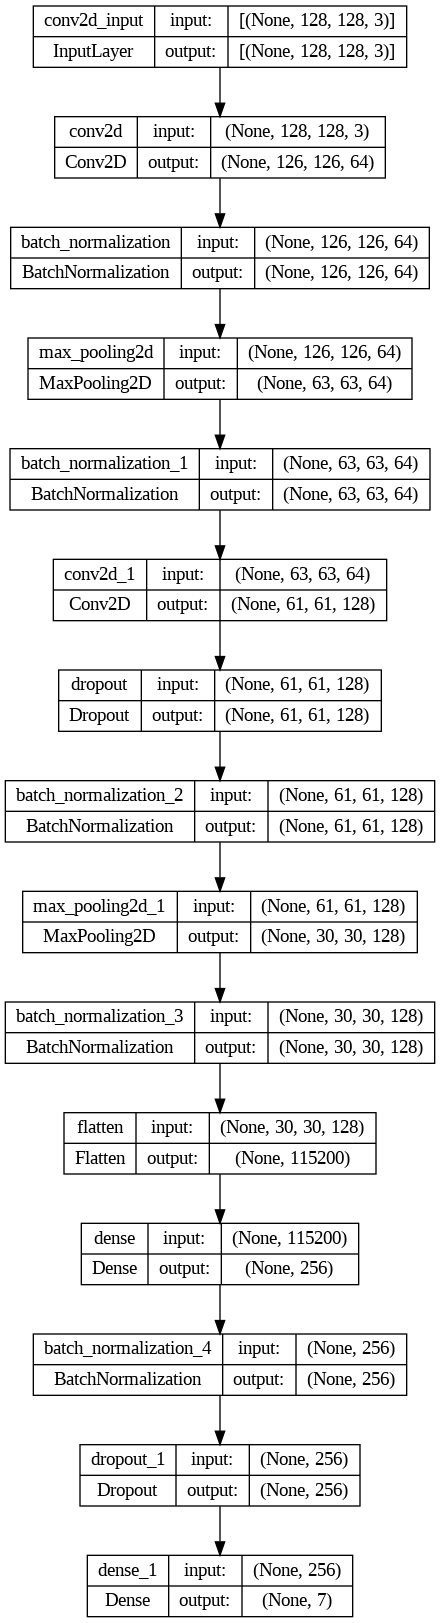

In [46]:
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [47]:
cnn_history = cnn.fit(X_train_img, y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 28s 399ms/step - loss: 2.5113 - accuracy: 0.3866 - val_loss: 26.7104 - val_accuracy: 0.6697
Epoch 2/30
22/22 [==============================] - 2s 86ms/step - loss: 1.6924 - accuracy: 0.5317 - val_loss: 6.1443 - val_accuracy: 0.6681
Epoch 3/30
22/22 [==============================] - 2s 86ms/step - loss: 1.3277 - accuracy: 0.6343 - val_loss: 2.1678 - val_accuracy: 0.6697
Epoch 4/30
22/22 [==============================] - 2s 85ms/step - loss: 1.0912 - accuracy: 0.6994 - val_loss: 1.6805 - val_accuracy: 0.6735
Epoch 5/30
22/22 [==============================] - 2s 85ms/step - loss: 0.9445 - accuracy: 0.7322 - val_loss: 1.1439 - val_accuracy: 0.6793
Epoch 6/30
22/22 [==============================] - 2s 85ms/step - loss: 0.8200 - accuracy: 0.7537 - val_loss: 1.0963 - val_accuracy: 0.6843
Epoch 7/30
22/22 [==============================] - 2s 85ms/step - loss: 0.7209 - accuracy: 0.7725 - val_loss: 1.0298 - val_accuracy: 0.6826
Epoch 8/30

63/63 [==============================] - 0s 4ms/step
Accuracy score: 0.7234148776834748
F1 score: 0.683671950589177
Precision score: 0.6939131284822291
Recall score: 0.7234148776834748
63/63 [==============================] - 0s 3ms/step


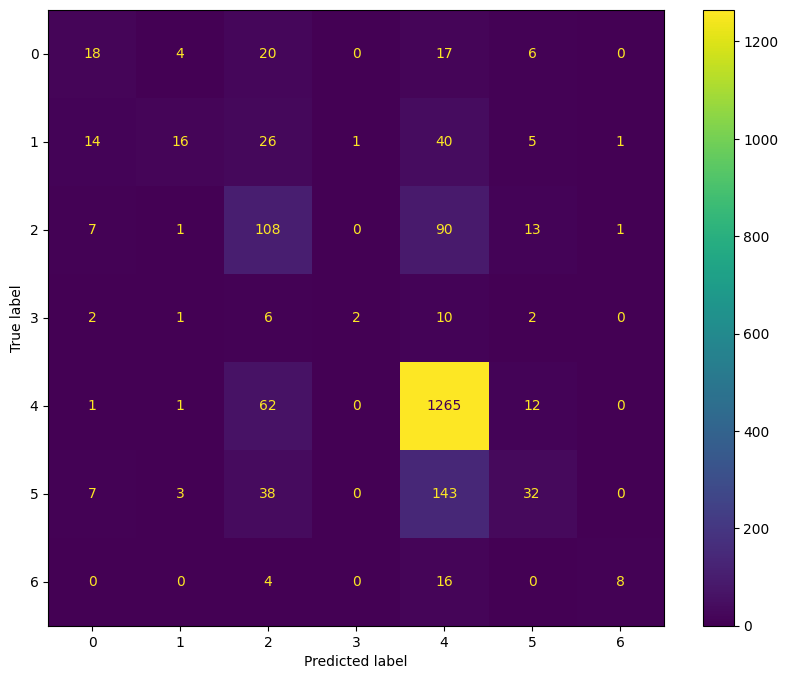

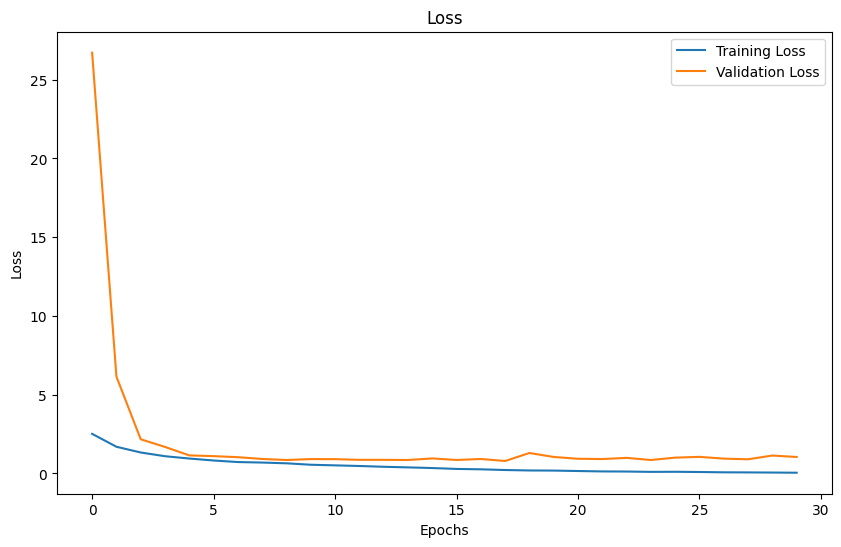

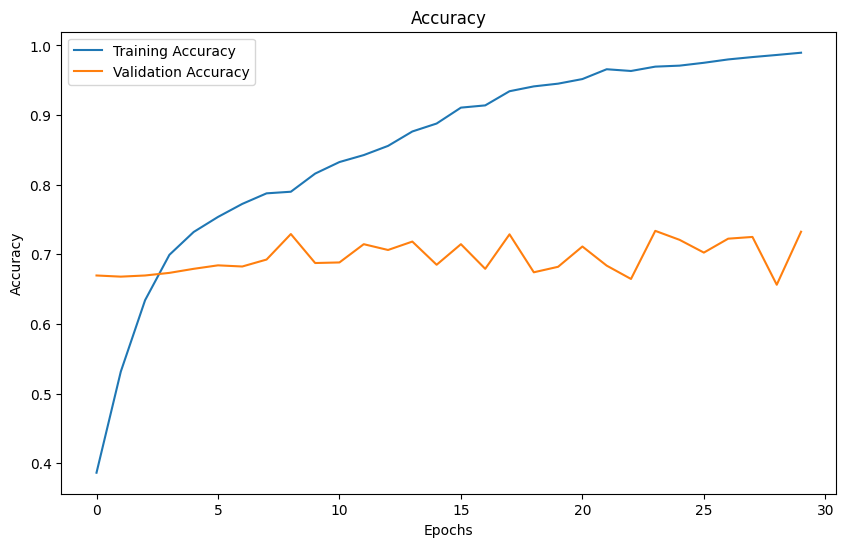

In [48]:
# Use the trained model to make predictions on the test data
output_metrics(cnn, X_test_img, y_test)
plot_confusion_matrix(cnn, X_test_img, y_test)
plot_loss(cnn_history)

# Visualisation Application

In [49]:
heatmap_images = []
raw_gradients = []

In [50]:
# Find the index of the last convolutional layer
last_conv_index = None
for i, layer in enumerate(cnn.layers[::-1]):
    if 'conv' in layer.name:
        last_conv_index = len(cnn.layers) - 1 - i
        break

if last_conv_index is not None:
    # Select the last convolutional layer
    last_conv_layer = cnn.get_layer(index=last_conv_index)

    # Create a new model with the last convolutional layer as output
    new_model = tf.keras.models.Model(inputs=cnn.input, outputs=[last_conv_layer.output, cnn.output])

    # Print information about the selected layer
    print("Selected layer name:", last_conv_layer.name)
    print("Selected layer output shape:", last_conv_layer.output_shape)
else:
    print("No convolutional layer found in the model.")

Selected layer name: conv2d_1
Selected layer output shape: (None, 61, 61, 128)


In [51]:
smoothgrad = Gradients()

In [52]:
images = df['path']

In [53]:
predictions = cnn.predict(X_test_img)

63/63 [==============================] - 0s 3ms/step


In [54]:
baseline = np.zeros(image_size)
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

In [55]:
# Initialize an empty DataFrame to store the collected samples
collected_samples = pd.DataFrame(columns=df.columns)

# Iterate over each unique class value
for class_value in range(6):
    # Filter the DataFrame to select samples with the current class value
    class_samples = df[df['cell_type_idx'] == class_value].sample(n=100, random_state=42)
    
    # Append the selected samples to the collected_samples DataFrame
    collected_samples = pd.concat([collected_samples, class_samples], ignore_index=True)

In [57]:
from tqdm import tqdm

images = collected_samples['path']

progress_bar = tqdm(total=len(images))

for img in images:
  img_arr = read_and_resize_image(image_path=img, size=image_size)
  im_tensor = PreprocessImages([img_arr])
  im = img_arr.astype(np.float32)
  vanilla_integrated_gradients_mask_3d = smoothgrad.GetSmoothedMask(
    im, call_model_function, call_model_args)
  raw_gradients.append(vanilla_integrated_gradients_mask_3d)
  
  # Update the progress bar
  progress_bar.update(1)

# Close the progress bar
progress_bar.close()


 12%|█▏        | 72/600 [00:57<07:05,  1.24it/s]

100%|██████████| 600/600 [04:57<00:00,  2.02it/s]


In [58]:
segment_image_list = load_images_from_folder("/content/content/HAM10000_segmentations_lesion_tschandl")

In [59]:
boolean_masks = []
for img in segment_image_list:
    boolean_masks.append(convert_to_boolean_mask(img))

In [60]:
overlap = []
for i in range(len(images)):
    per = [calculate_overlap(raw_gradients[i][:, :, 0], boolean_masks[i]), np.argmax(predictions, axis=1)[i]]
    if str(per[0]) != "nan":
      overlap.append(per)


<ipython-input-10-3225b9d9aa76>:11: RuntimeWarning: invalid value encountered in float_scalars
  overlap = (sum_mask_segment / total_sum) * 100


<Figure size 1000x600 with 0 Axes>

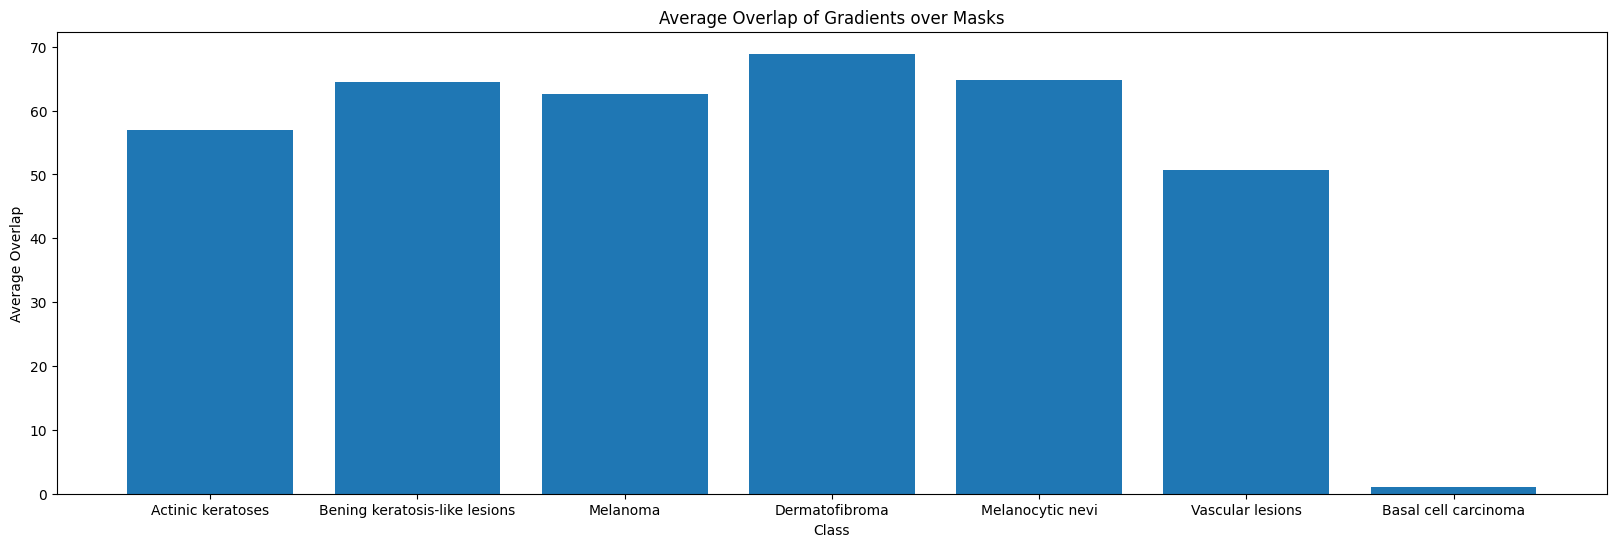

In [61]:
from collections import defaultdict

# Calculate average overlap for each class
class_overlaps = defaultdict(list)
for item in overlap:
    overlap_value = item[0]
    class_label = item[1]
    class_overlaps[class_label].append(overlap_value)

class_labels = []
average_overlaps = []

for class_label, overlaps in class_overlaps.items():
    class_labels.append(class_label)
    average_overlap = sum(overlaps) / len(overlaps)
    average_overlaps.append(average_overlap)

# Create a bar chart or scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference

mapped_labels = [list(lesion_type_dict.values())[label] for label in class_labels]

plt.figure(figsize=(20, 6))
# Bar chart
plt.bar(range(len(average_overlaps)), average_overlaps)
plt.xticks(range(len(average_overlaps)), mapped_labels)
plt.xlabel('Class')
plt.ylabel('Average Overlap')
plt.title('Average Overlap of Gradients over Masks')

plt.show()

In [62]:
for label, overlap in zip(mapped_labels, average_overlaps):
    print(f"Label: {label}, Average Overlap: {overlap}")

Label: Actinic keratoses, Average Overlap: 56.92481416146963
Label: Bening keratosis-like lesions, Average Overlap: 64.46726859197952
Label: Melanoma, Average Overlap: 62.54517535368601
Label: Dermatofibroma, Average Overlap: 68.91297921538353
Label: Melanocytic nevi, Average Overlap: 64.84830178320408
Label: Vascular lesions, Average Overlap: 50.68961197608396
Label: Basal cell carcinoma, Average Overlap: 0.9955991059541702


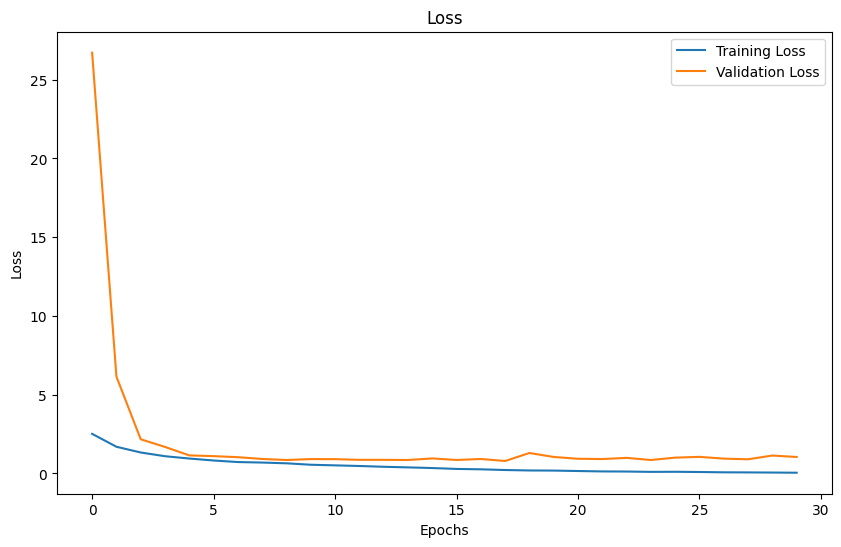

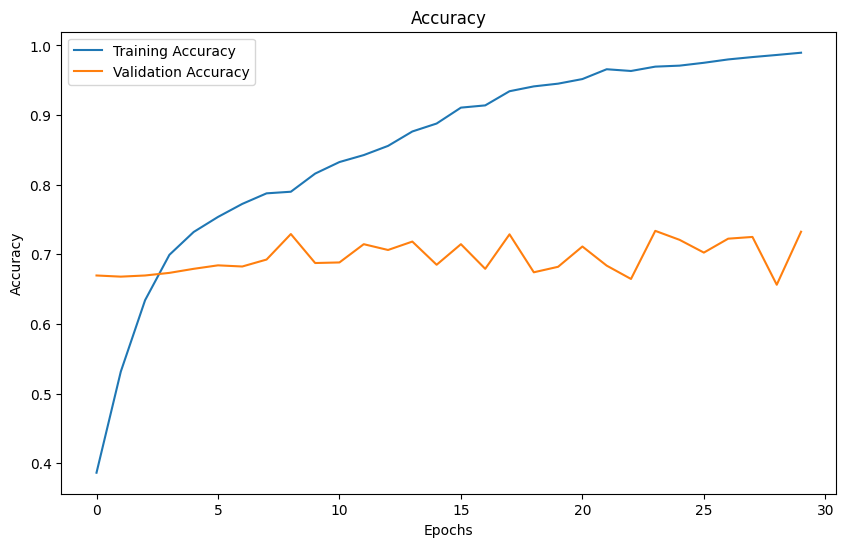

In [63]:
plot_loss(cnn_history)

# MLP

In [64]:
def perceptron():
  model = Sequential()
  model.add(Input(shape=(3,)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [65]:
perceptron = perceptron()
perceptron.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

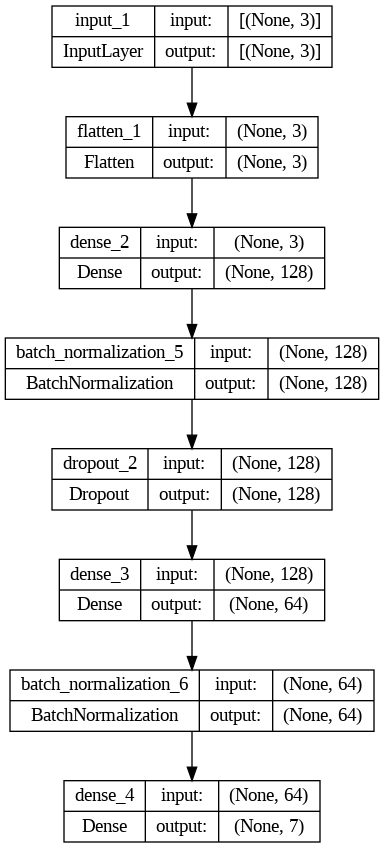

In [66]:
plot_model(perceptron, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [67]:
sex_dict = {
    'male': 0.0,
    'female': 1.0,
    'unknown': 1.5
}

loc_dict = {
    'back': 1.0,
    'lower extremity': 2.0,
    'trunk': 3.0,
    'upper extremity': 4.0,
    'abdomen': 5.0,
    'face': 6.0,
    'chest': 7.0,
    'foot': 8.0,
    'unknown': 9.0,
    'neck': 10.0,
    'scalp': 11.0,
    'hand': 12.0,
    'ear': 13.0,
    'genital': 14.0,
    'acral': 15.0
}

In [68]:
train_df = train_df.replace({"sex": sex_dict})
train_df = train_df.replace({"localization": loc_dict})
test_df = test_df.replace({"sex": sex_dict})
test_df = test_df.replace({"localization": loc_dict})

In [69]:
#Extract and recombine the demographic data for training set and test set
X_train_demo = np.stack((np.asarray(train_df['age'].values), np.asarray(train_df['sex'].values), np.asarray(train_df['localization'].values)))
y_train = train_df['cell_type_idx'].values
X_test_demo = np.stack((np.asarray(test_df['age'].values), np.asarray(test_df['sex'].values), np.asarray(test_df['localization'].values)))
y_test = test_df['cell_type_idx'].values

X_train_demo=X_train_demo.T.astype(int)
X_test_demo=X_test_demo.T.astype(int)

In [70]:
perceptron_history = perceptron.fit(X_train_demo, y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 2s 14ms/step - loss: 2.0991 - accuracy: 0.4087 - val_loss: 11.0788 - val_accuracy: 0.1177
Epoch 2/30
22/22 [==============================] - 0s 6ms/step - loss: 1.7285 - accuracy: 0.5517 - val_loss: 7.1641 - val_accuracy: 0.1348
Epoch 3/30
22/22 [==============================] - 0s 6ms/step - loss: 1.5762 - accuracy: 0.5811 - val_loss: 5.3075 - val_accuracy: 0.1785
Epoch 4/30
22/22 [==============================] - 0s 6ms/step - loss: 1.4619 - accuracy: 0.6002 - val_loss: 3.6245 - val_accuracy: 0.2592
Epoch 5/30
22/22 [==============================] - 0s 6ms/step - loss: 1.3673 - accuracy: 0.6225 - val_loss: 2.4191 - val_accuracy: 0.3860
Epoch 6/30
22/22 [==============================] - 0s 6ms/step - loss: 1.2751 - accuracy: 0.6334 - val_loss: 1.6382 - val_accuracy: 0.5133
Epoch 7/30
22/22 [==============================] - 0s 6ms/step - loss: 1.1999 - accuracy: 0.6448 - val_loss: 1.2801 - val_accuracy: 0.5982
Epoch 8/30
22/22 [

63/63 [==============================] - 0s 1ms/step
Accuracy score: 0.6804792810783824
F1 score: 0.5845682674098588
Precision score: 0.5147370774623242
Recall score: 0.6804792810783824
63/63 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


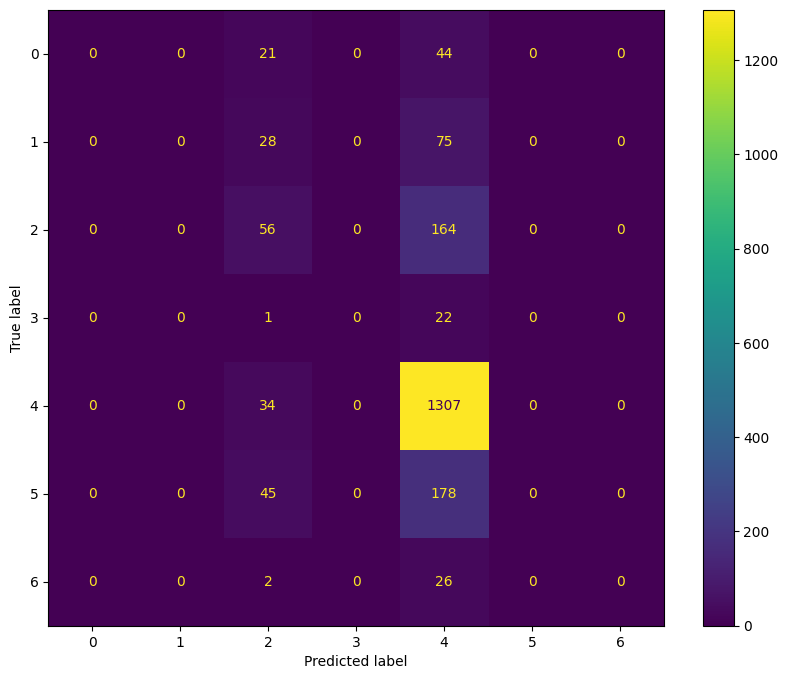

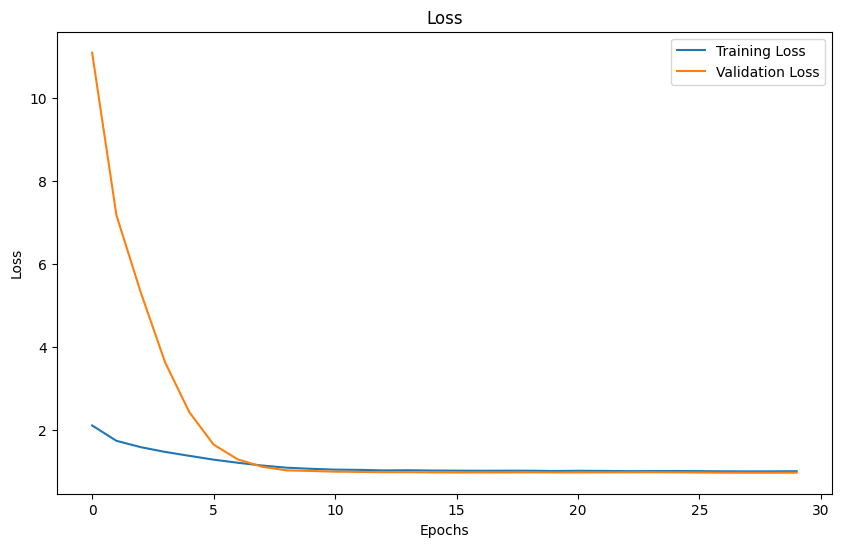

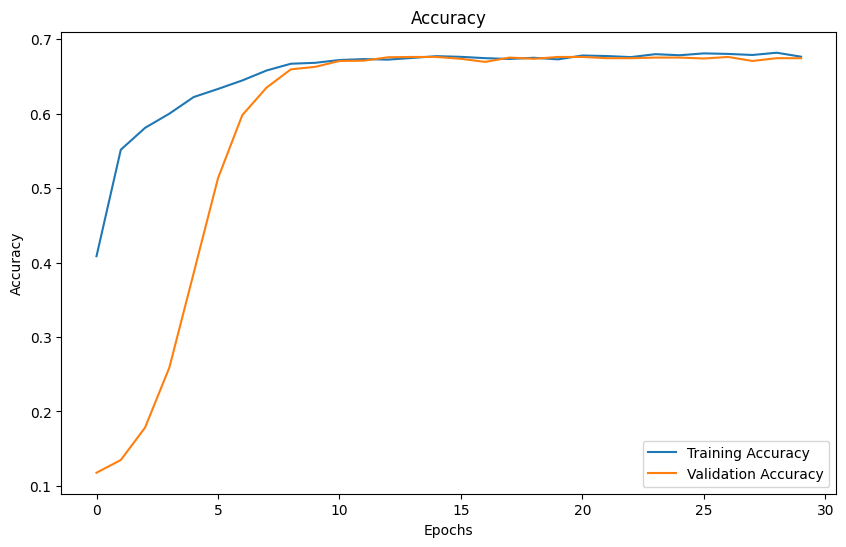

In [71]:
# Use the trained model to make predictions on the test data
output_metrics(perceptron, X_test_demo, y_test)
plot_confusion_matrix(perceptron, X_test_demo, y_test)
plot_loss(perceptron_history)

# Combined 1 - Training the combined model with the previously trained CNN and perceptron

In [72]:
concatenated_inputs = concatenate(inputs=[perceptron.output, cnn.output])
x = Dense(128, activation="relu")(concatenated_inputs)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, cnn.input], outputs=x)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [73]:
model_history = model.fit([X_train_demo, X_train_img], y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 8s 105ms/step - loss: 1.5007 - accuracy: 0.7723 - val_loss: 1.1994 - val_accuracy: 0.7042
Epoch 2/30
22/22 [==============================] - 2s 87ms/step - loss: 0.7340 - accuracy: 0.8723 - val_loss: 0.8827 - val_accuracy: 0.7121
Epoch 3/30
22/22 [==============================] - 2s 88ms/step - loss: 0.3742 - accuracy: 0.9244 - val_loss: 0.9843 - val_accuracy: 0.7167
Epoch 4/30
22/22 [==============================] - 2s 87ms/step - loss: 0.2443 - accuracy: 0.9379 - val_loss: 1.6597 - val_accuracy: 0.6718
Epoch 5/30
22/22 [==============================] - 2s 88ms/step - loss: 0.2354 - accuracy: 0.9403 - val_loss: 1.4523 - val_accuracy: 0.6872
Epoch 6/30
22/22 [==============================] - 2s 88ms/step - loss: 0.2218 - accuracy: 0.9408 - val_loss: 1.1676 - val_accuracy: 0.5953
Epoch 7/30
22/22 [==============================] - 2s 88ms/step - loss: 0.1703 - accuracy: 0.9519 - val_loss: 1.2287 - val_accuracy: 0.6269
Epoch 8/30
2

63/63 [==============================] - 0s 3ms/step
Accuracy score: 0.6660009985022466
F1 score: 0.5458547523399954
Precision score: 0.5275369953452168
Recall score: 0.6660009985022466
18/63 [=======>......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 0s 3ms/step


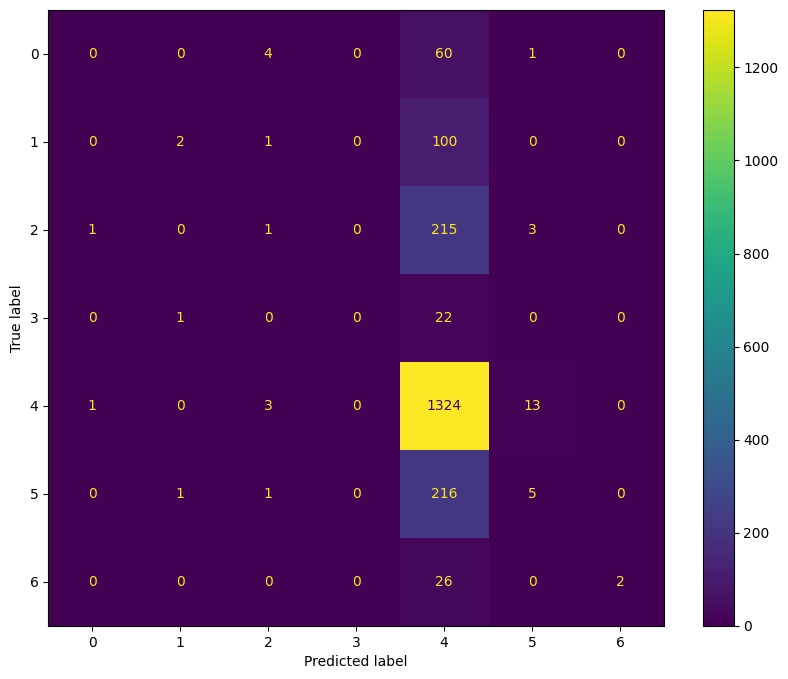

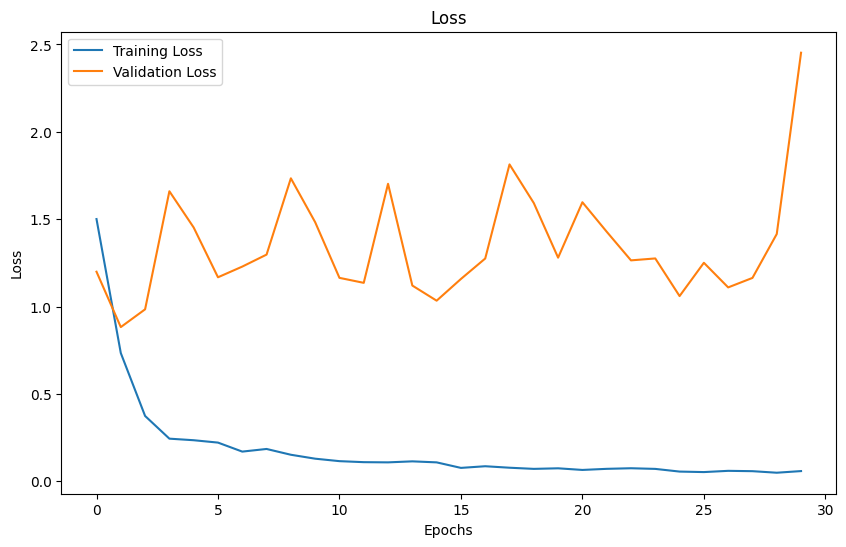

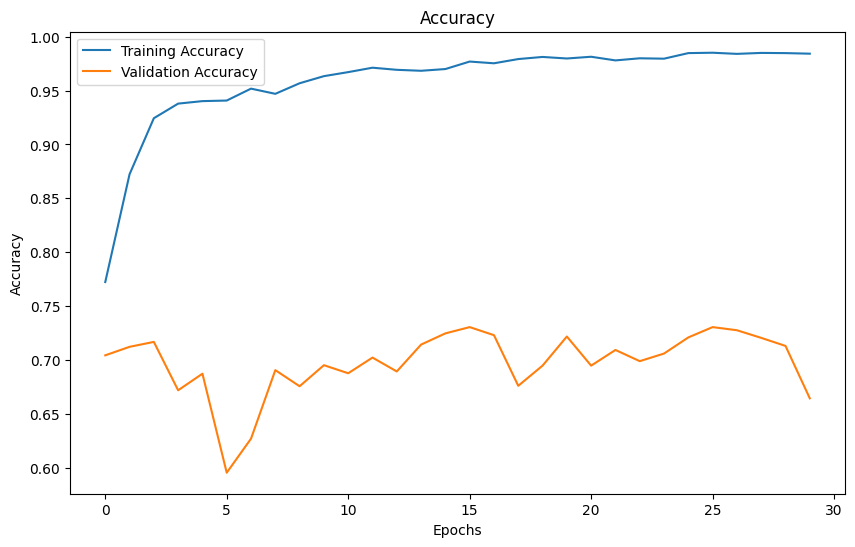

In [74]:
output_metrics(model, [X_test_demo, X_test_img], y_test)
plot_confusion_matrix(model, [X_test_demo, X_test_img], y_test)
plot_loss(model_history)

# Combined 2 - Training the combined model from scratch

In [75]:
def cnn():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

def perceptron():
  model = Sequential()
  model.add(Input(shape=(3,)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [76]:
perceptron = perceptron()
cnn = cnn()
#create an input for the final layers from the concatenated outputs of both subnetworks
combinedInput = concatenate(inputs=[perceptron.output, cnn.output])

#simple Multi-Layer Perceptron with Dense Layers
x = Dense(128, activation="relu")(combinedInput)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, cnn.input], outputs=x)

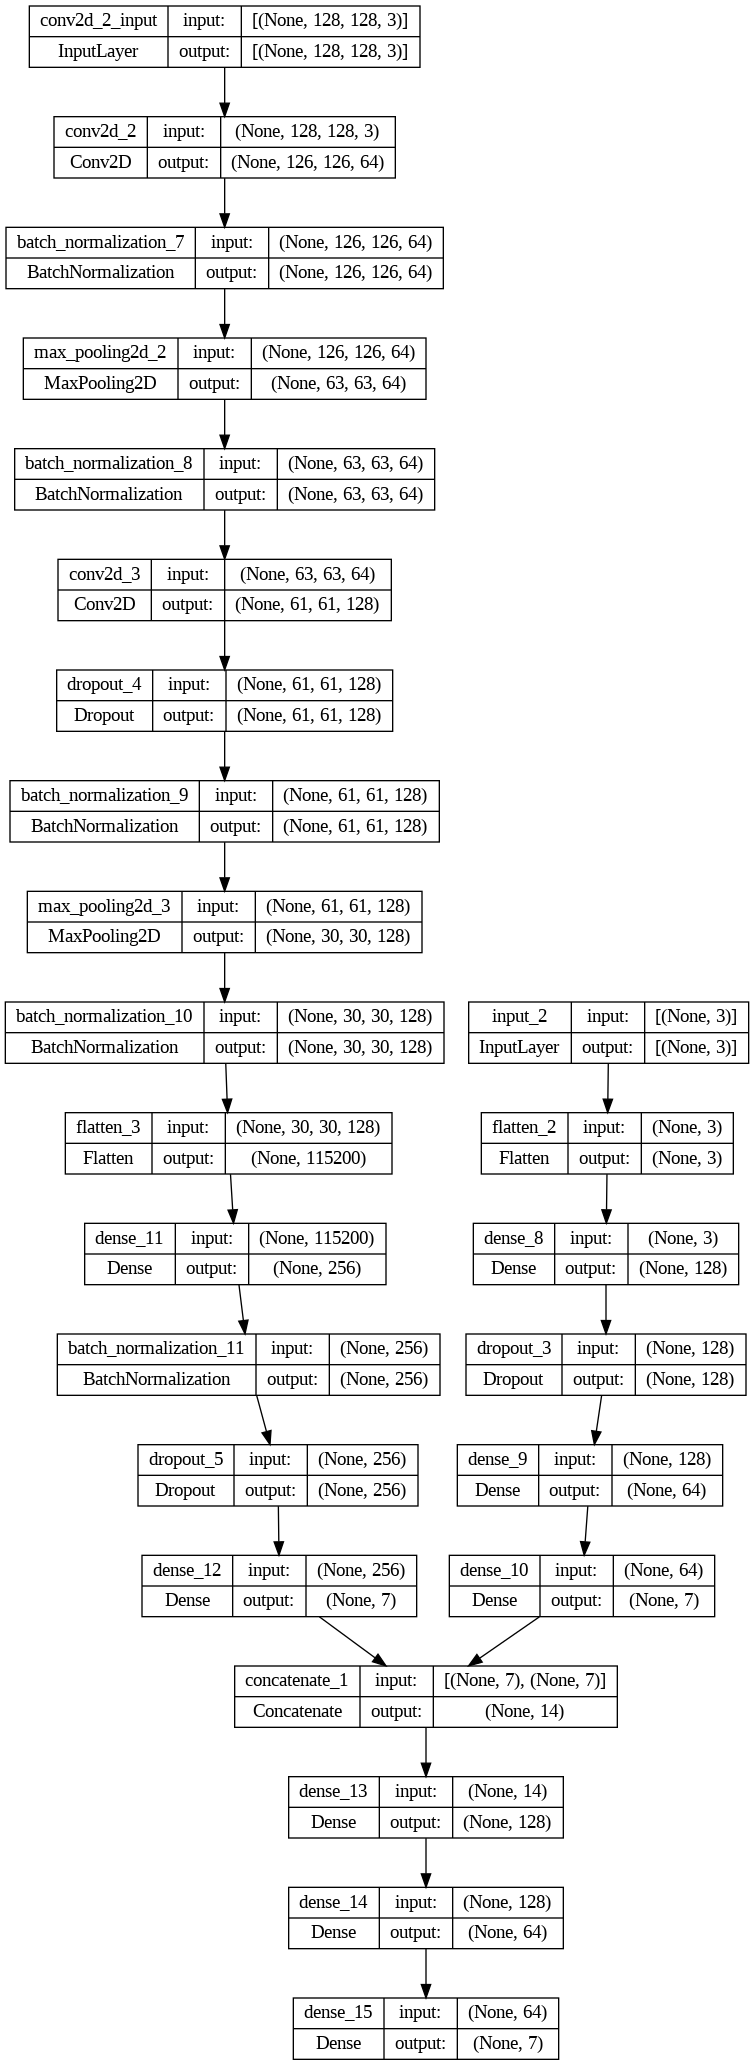

In [77]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [78]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model_history = model.fit([X_train_demo, X_train_img], y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 7s 106ms/step - loss: 1.6021 - accuracy: 0.5852 - val_loss: 1.2519 - val_accuracy: 0.6710
Epoch 2/30
22/22 [==============================] - 2s 87ms/step - loss: 1.1199 - accuracy: 0.6689 - val_loss: 1.2756 - val_accuracy: 0.6710
Epoch 3/30
22/22 [==============================] - 2s 87ms/step - loss: 0.9873 - accuracy: 0.6689 - val_loss: 1.1738 - val_accuracy: 0.6710
Epoch 4/30
22/22 [==============================] - 2s 87ms/step - loss: 0.9206 - accuracy: 0.6689 - val_loss: 1.2748 - val_accuracy: 0.6710
Epoch 5/30
22/22 [==============================] - 2s 87ms/step - loss: 0.8867 - accuracy: 0.6737 - val_loss: 1.1216 - val_accuracy: 0.6186
Epoch 6/30
22/22 [==============================] - 2s 87ms/step - loss: 0.8689 - accuracy: 0.6813 - val_loss: 1.3085 - val_accuracy: 0.6718
Epoch 7/30
22/22 [==============================] - 2s 87ms/step - loss: 0.8529 - accuracy: 0.6815 - val_loss: 0.8947 - val_accuracy: 0.6851
Epoch 8/30
2

63/63 [==============================] - 0s 3ms/step
Accuracy score: 0.6145781328007988
F1 score: 0.6230686696878168
Precision score: 0.697852692973217
Recall score: 0.6145781328007988
18/63 [=======>......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 0s 3ms/step


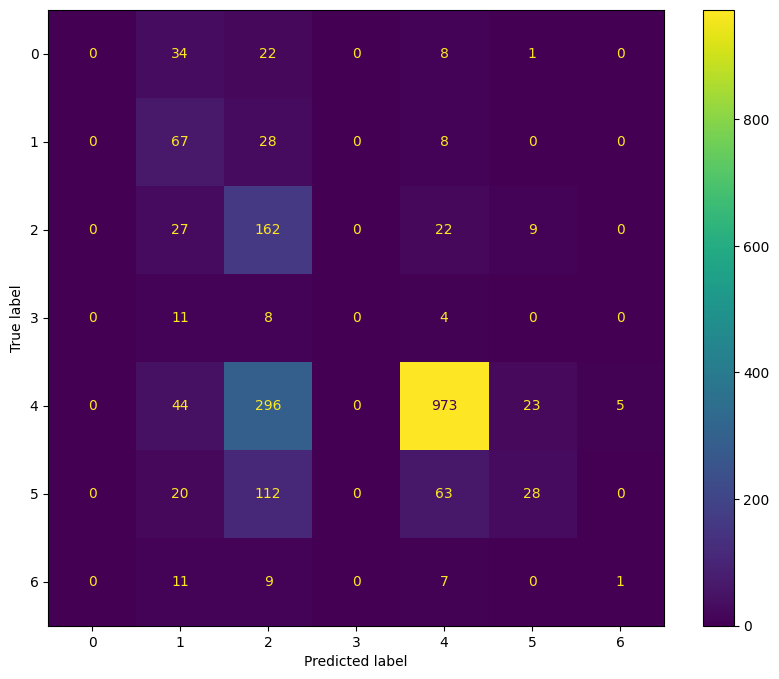

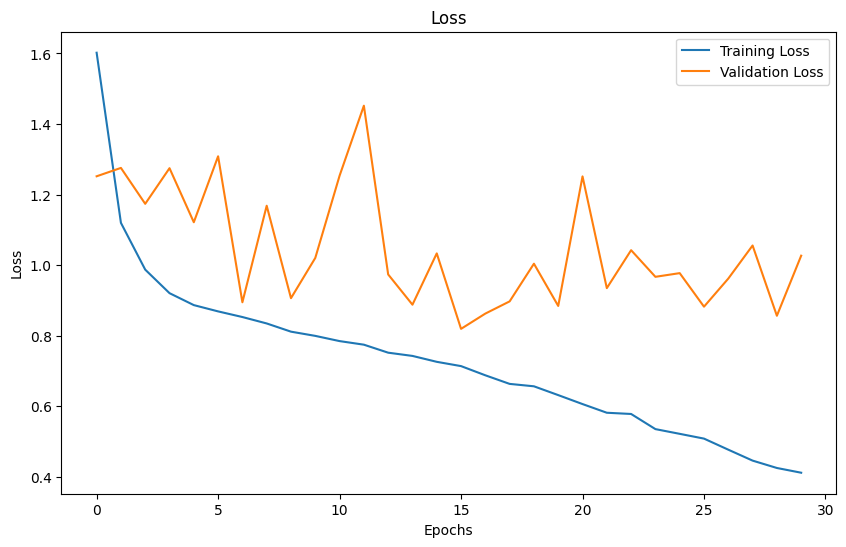

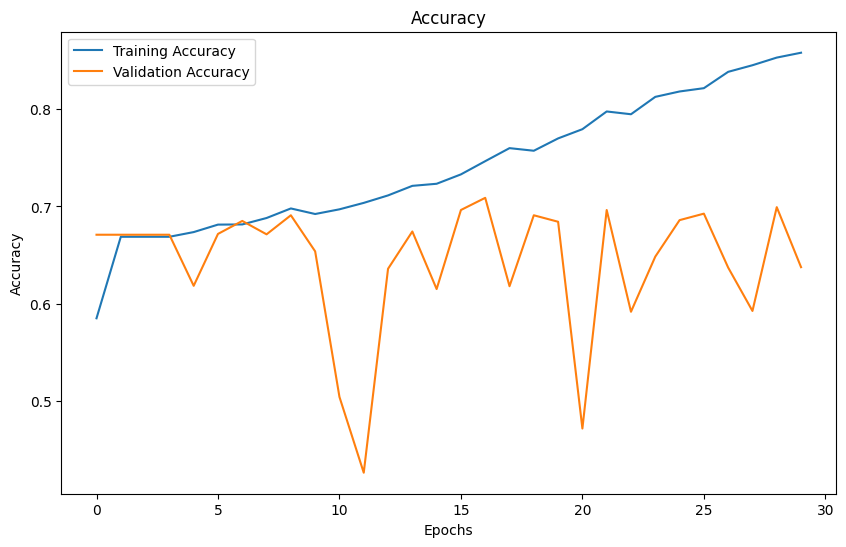

In [79]:
output_metrics(model, [X_test_demo, X_test_img], y_test)
plot_confusion_matrix(model, [X_test_demo, X_test_img], y_test)
plot_loss(model_history)